### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [33]:
data = np.load('/home/shwetha/ASTR_3300_S2025/coursework/homeworks/hw_data/hw8_data_1.npy')
print("Column names:", data.dtype.names)

u = data['u']
g = data['g']
r = data['r']
i = data['i']
z = data['z']

u_g=u-g
g_r=g-r
r_i=r-i
i_z=i-z

redshift = data['redshift']
spec_class = data['specClass']

counts = collections.Counter(spec_class)
print("Class counts:", counts)

Column names: ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
Class counts: Counter({np.str_('GALAXY'): 42808, np.str_('QSO'): 7192})


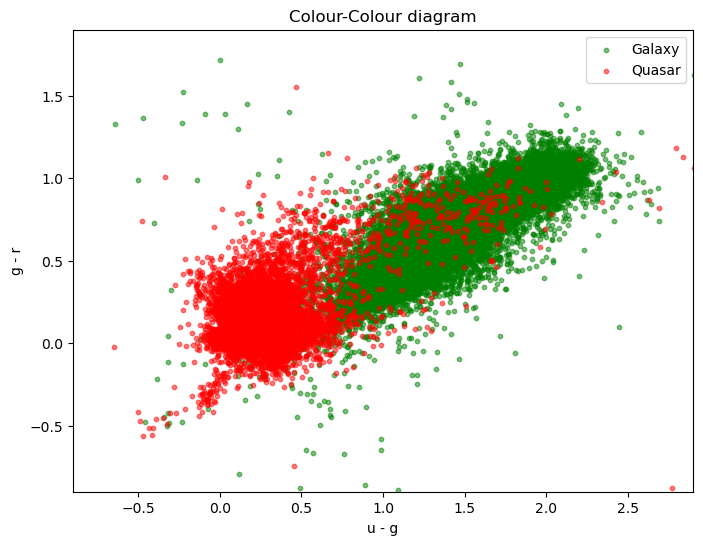

In [42]:
galaxy = (spec_class == 'GALAXY')
quasar = (spec_class == 'QSO')

plt.figure(figsize=(8, 6))
plt.scatter(u_g[galaxy], g_r[galaxy], alpha=0.5, label='Galaxy', s=10, color='green')
plt.scatter(u_g[quasar], g_r[quasar], alpha=0.5, label='Quasar', s=10, color='red')
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.xlim(-0.9, 2.9)
plt.ylim(-0.9, 1.9)
plt.legend()
plt.title('Colour-Colour diagram')
plt.show()


In [43]:
X = np.vstack([u_g, g_r, r_i, i_z, redshift]).T
y = (spec_class == 'QSO').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

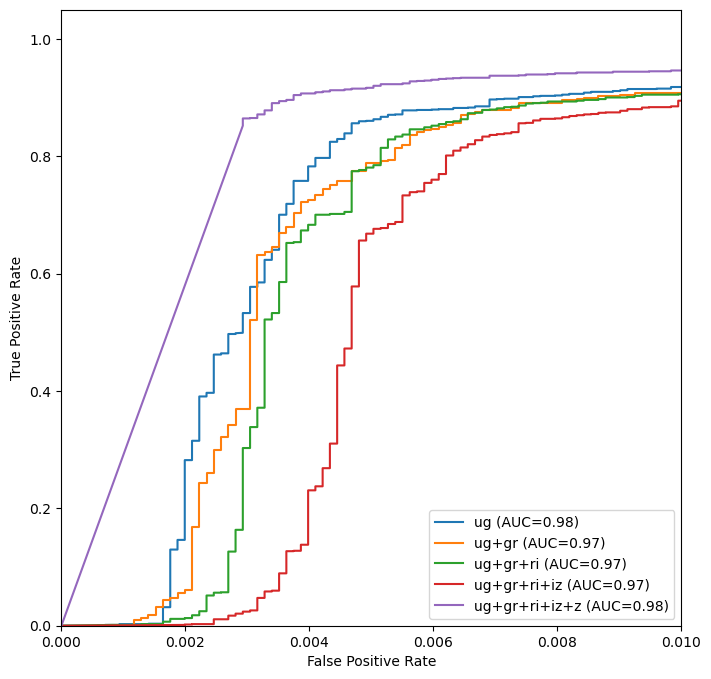

In [46]:
plt.figure(figsize=(8, 8))

features = ['ug','gr','ri','iz','z']
for i in range(1,6):
    gnb = GaussianNB()
    gnb.fit(X_train[:,:i], y_train)
    y_prob=gnb.predict_proba(X_test[:,:i])[:, gnb.classes_ == 1].ravel()
    fpr, tpr, _=roc_curve(y_test, y_prob)
    roc_auc=auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{"+".join(features[:i])} (AUC={roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,0.01)
plt.ylim(0,1.05)
plt.legend()
plt.show()

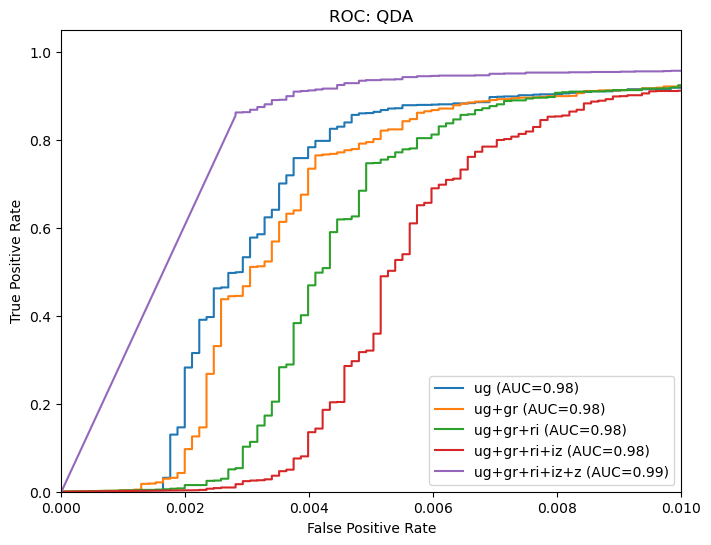

In [62]:
plt.figure(figsize=(8, 6))

for i in range(1,6):
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train[:,:i], y_train)
    y_prob = qda.predict_proba(X_test[:,:i])[:,qda.classes_ == 1].ravel()
    fpr,tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{"+".join(features[:i])} (AUC={roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,0.01)
plt.ylim(0,1.05)
plt.legend()
plt.title('ROC: QDA')
plt.show()

/tmp/ipykernel_66817/573879883.py:12: RuntimeWarning: invalid value encountered in divide
  y_prob = np.exp(logprob_1) / (np.exp(logprob_0) + np.exp(logprob_1))


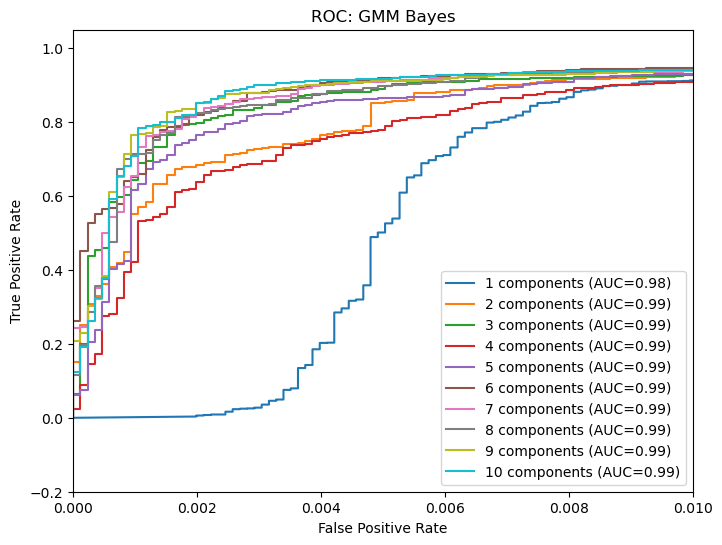

Best GMM components: 8


In [54]:
best_auc = 0
best_n = 0

plt.figure(figsize=(8,6))
for n in range(1,11):
    gmm0 = GaussianMixture(n_components=n).fit(X_train[y_train == 0,:4])
    gmm1 = GaussianMixture(n_components=n).fit(X_train[y_train == 1,:4])
    
    logprob_0 = gmm0.score_samples(X_test[:,:4])
    logprob_1 = gmm1.score_samples(X_test[:,:4])
    
    y_prob = np.exp(logprob_1) / (np.exp(logprob_0) + np.exp(logprob_1))
    y_prob = np.nan_to_num(y_prob, nan=0.0, posinf=1.0, neginf=0.0)
    fpr, tpr, _ = roc_curve(y_test,y_prob)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc:
        best_auc, best_n = roc_auc, n
    plt.plot(fpr, tpr, label=f'{n} components (AUC={roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 0.01)
plt.ylim(-0.2, 1.05)
plt.legend()
plt.title('ROC: GMM Bayes')
plt.show()

print("Best GMM components:", best_n)

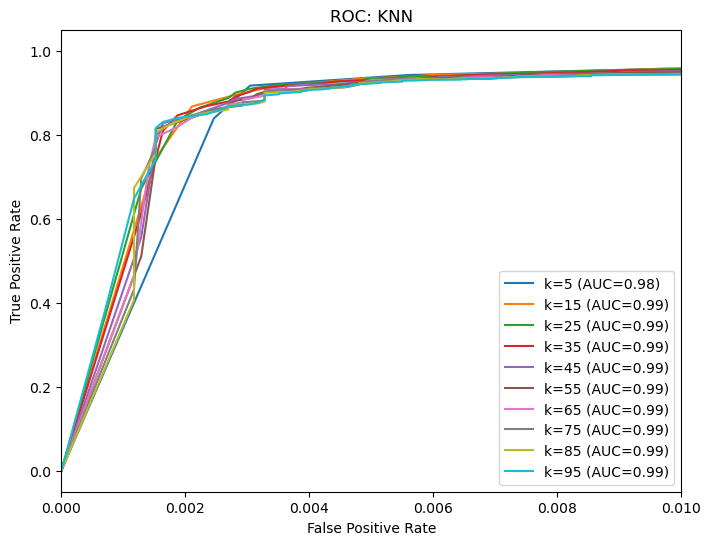

Best K: 95


In [58]:
plt.figure(figsize=(8, 6))
best_auc_knn = 0
best_k = 0

for k in range(5, 101, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train[:, :4], y_train)
    y_prob = knn.predict_proba(X_test[:, :4])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc_knn:
        best_auc_knn, best_k = roc_auc, k
    plt.plot(fpr, tpr, label=f'k={k} (AUC={roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 0.01)
plt.legend()
plt.title('ROC: KNN')
plt.show()

print("Best K:", best_k)

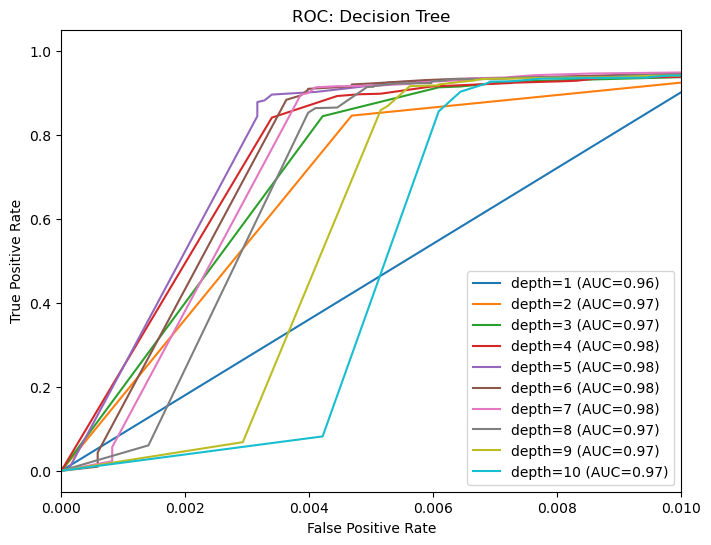

Best DT depth: 6


In [59]:
plt.figure(figsize=(8, 6))
best_auc_dt = 0
best_depth = 0

for depth in range(1, 11):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train[:, :4], y_train)
    y_prob = tree.predict_proba(X_test[:, :4])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc_dt:
        best_auc_dt, best_depth = roc_auc, depth
    plt.plot(fpr, tpr, label=f'depth={depth} (AUC={roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 0.01)
plt.legend()
plt.title('ROC: Decision Tree')
plt.show()

print("Best DT depth:", best_depth)

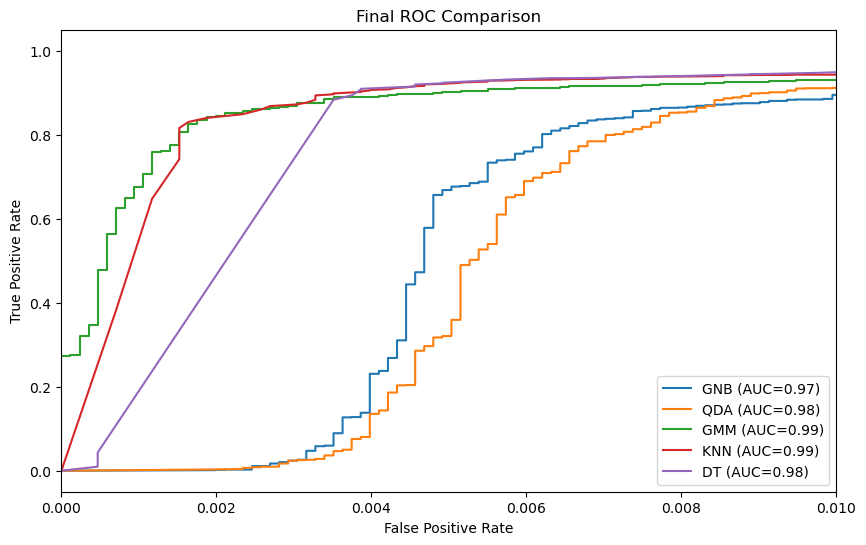

In [60]:
gnb = GaussianNB().fit(X_train[:, :4], y_train)
qda = QuadraticDiscriminantAnalysis().fit(X_train[:, :4], y_train)
gmm0 = GaussianMixture(n_components=best_n).fit(X_train[y_train == 0, :4])
gmm1 = GaussianMixture(n_components=best_n).fit(X_train[y_train == 1, :4])
knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_train[:, :4], y_train)
dt = DecisionTreeClassifier(max_depth=best_depth).fit(X_train[:, :4], y_train)

probs = {
    'GNB': gnb.predict_proba(X_test[:, :4])[:, 1],
    'QDA': qda.predict_proba(X_test[:, :4])[:, 1],
    'GMM': np.exp(gmm1.score_samples(X_test[:, :4])) / 
           (np.exp(gmm0.score_samples(X_test[:, :4])) + np.exp(gmm1.score_samples(X_test[:, :4]))),
    'KNN': knn.predict_proba(X_test[:, :4])[:, 1],
    'DT': dt.predict_proba(X_test[:, :4])[:, 1],
}

plt.figure(figsize=(10, 6))
for name, y_prob in probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 0.01)
plt.legend()
plt.title('Final ROC Comparison')
plt.show()


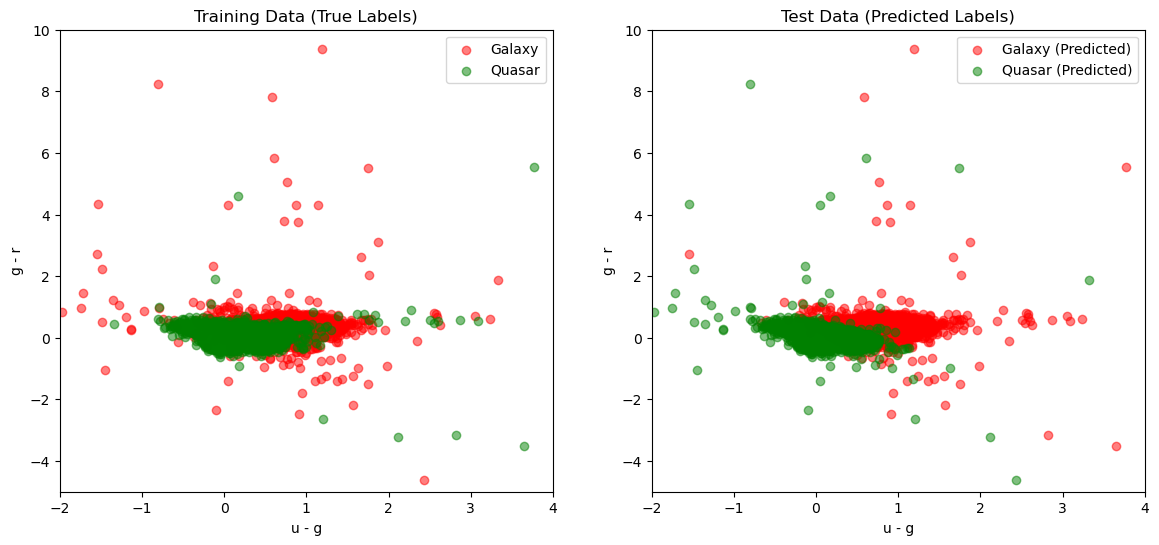

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ug = X_train[:, 0] - X_train[:, 1]
gr = X_train[:, 1] - X_train[:, 2]

# Training data (true labels)
ax1.scatter(ug[y_train == 0], gr[y_train == 0], label='Galaxy', alpha=0.5, color='red')
ax1.scatter(ug[y_train == 1], gr[y_train == 1], label='Quasar', alpha=0.5, color='green')
ax1.set_title("Training Data (True Labels)")
ax1.set_xlabel("u - g")
ax1.set_ylabel("g - r")
ax1.set_ylim(-5,10)
ax1.set_xlim(-2,4)
ax1.legend()

y_pred_best = knn.predict(X_train[:, :4])
ax2.scatter(ug[y_pred_best == 0], gr[y_pred_best == 0], label='Galaxy (Predicted)', alpha=0.5, color='red')
ax2.scatter(ug[y_pred_best == 1], gr[y_pred_best == 1], label='Quasar (Predicted)', alpha=0.5, color='green')
ax2.set_title("Test Data (Predicted Labels)")
ax2.set_xlabel("u - g")
ax2.set_ylabel("g - r")
ax2.set_ylim(-5,10)
ax2.set_xlim(-2,4)
ax2.legend()
plt.show()

<span style="color:green">NP: Correct! Good job! </span>